In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.models import load_model
import datetime
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler
from pydub import AudioSegment
from scipy.signal import resample

C:\Users\syj47\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
uploaded_file_name = 'what.wav'
EXPECTED_SAMPLE_RATE = 44100

def convert_audio_for_model(user_file, output_file = 'what2.wav'):
    audio = AudioSegment.from_file(user_file, format = "wav")
    audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
    audio.export(output_file, format="wav")
    return output_file

converted_audio_file = convert_audio_for_model(uploaded_file_name)

# Loading audio samples from the wav file : 
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

In [3]:
# 오디오 정보 출력
duration = len(audio_samples)/sample_rate
print("data :", audio_samples)
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

data : [128 128 128 ... 128 128 128]
Sample rate: 44100 Hz
Total duration: 9.64s
Size of the input: 424965


In [5]:
# 종재
pd.DataFrame(audio_samples).to_csv("what.csv")
data = pd.read_csv('what.csv')
train_data = data['0'].values/1000
print(data['0'].describe())
print(train_data)

count    424965.000000
mean        125.832344
std           8.581482
min          91.000000
25%         120.000000
50%         126.000000
75%         132.000000
max         165.000000
Name: 0, dtype: float64
[0.128 0.128 0.128 ... 0.128 0.128 0.128]


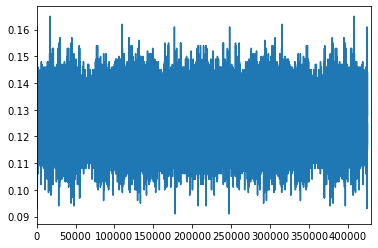

In [6]:
plt.plot(train_data)
plt.xlim(0,430000)
plt.show()

In [7]:
# 5초 간의 데이터를 보고 다음을 예측
seq_len = 50  #예측을 위한 데이터 수
prediction = 1  # 다음을 예측할 데이터 수 
print("seq_len : ", seq_len)
sequence_length = seq_len + prediction

seq_len :  50


In [8]:
# 정확한 예측을 위해 값들을 정규화 
result = []
for index in range(len(train_data) - sequence_length):
    result.append(train_data[index: index + sequence_length])
result = np.array(result)

# 트레이닝할 값과 테스트 값을 나눠줌
row = int(round(result.shape[0] * 0.1))
train = result[:row, :]

x_train = train[:, :-prediction]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -prediction]

x_test = result[row:, :-prediction]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -prediction]


In [9]:
# 모델 생성
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50,1)))  # (timestep, feature)
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop', metrics=["acc"])
model.summary()

# 트레이닝 값으로 학습
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=5)

# 모델 저장
model.save('weight.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4250/4250 [==============================] - 600s 137ms/step - loss: 1.0902e-04 - acc: 0.0000e+00 - val_loss: 5.9144e-06 - val_acc: 0.0000e+00
Epoch 2/5
4250/4250 [==============================] - 514s 121ms/step - loss: 1.3529e-05 - acc: 0.0000e+00 - val_loss: 1.5188e-05 - val_acc: 0.0000e+00
Epoch 3/5
4250/4250 [==============================] - 537s 126ms/step - los

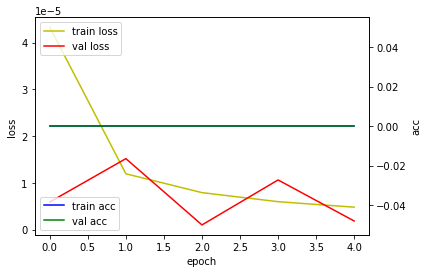

In [10]:
# 모델 학습 과정 표시
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('acc')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [11]:
# 모델 로드
model = Sequential()
model = load_model('weight.h5')

In [12]:
pred = model.predict(x_test)
pred

array([[0.1337296 ],
       [0.13347465],
       [0.1329864 ],
       ...,
       [0.12682393],
       [0.12629057],
       [0.1260399 ]], dtype=float32)

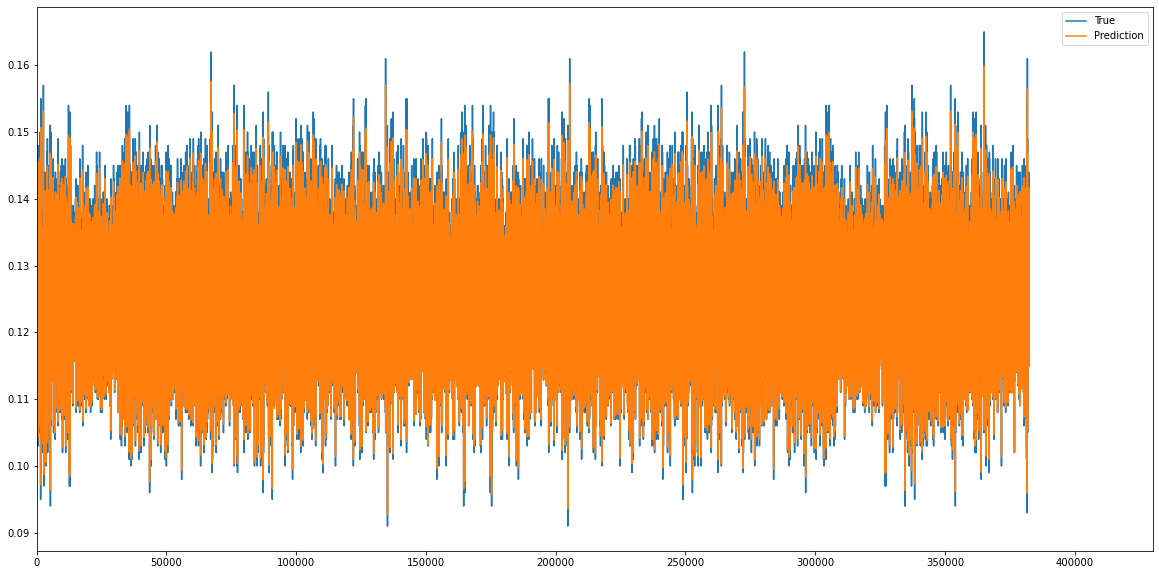

In [13]:
# 그래프 
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.xlim(0,430000)
plt.show()

In [14]:
# 예측값을 wav로 출력
EXPECTED_SAMPLE_RATE = 44100
pred = pred * 1000 / EXPECTED_SAMPLE_RATE
y_test = y_test * 1000 / EXPECTED_SAMPLE_RATE

wavfile.write("pred.wav", EXPECTED_SAMPLE_RATE, pred)
wavfile.write("y_test.wav", EXPECTED_SAMPLE_RATE, y_test)
print("end")

end
